[link text](https://)# Pre-Trained Word Embeddings for Text Classification

# Imports/Installations

In [3]:
!pip install transformers
!pip install -U datasets

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
from collections import defaultdict, Counter
import json
import numpy as np
import torch
import pandas as pd

from matplotlib import pyplot as plt

from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from datasets import load_dataset, DatasetDict
from torch.utils.data import DataLoader
from transformers import DistilBertConfig, DistilBertTokenizer, DistilBertForSequenceClassification, DistilBertModel
from transformers import get_linear_schedule_with_warmup
from tqdm.notebook import tqdm
from torch.optim import AdamW
from transformers import set_seed
from sklearn.metrics import accuracy_score, f1_score
from datasets import load_dataset, DatasetDict, Dataset
from torch.utils.data import DataLoader

# Loading and formatting CSVs

In [6]:
# OLD 60/20/20 DATA SPLIT

# df = pd.read_csv('/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Data/Labeled Data/BERTopic_results.csv')
# test = pd.read_csv('/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Data/Labeled Data/BERTopic_TEST.csv')
# train = pd.read_csv('/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Data/Labeled Data/BERTopic_TRAIN.csv')
# validation = pd.read_csv('/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Data/Labeled Data/BERTopic_VAL.csv')

# # turning into hugging face format
# test = Dataset.from_pandas(test)
# train = Dataset.from_pandas(train)
# validation = Dataset.from_pandas(validation)

In [7]:
df = pd.read_csv('/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Data/Labeled Data/BERTopic_results.csv')
# test = pd.read_csv('/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Data/Labeled Data/BERTopic_TEST.csv')
train = pd.read_csv('/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Text Classification Models/Classification Data/Base/BERTopic_TRAIN_80.csv')
validation = pd.read_csv('/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Text Classification Models/Classification Data/Base/BERTopic_VAL_20.csv')

# turning into hugging face format
# test = Dataset.from_pandas(test)
train = Dataset.from_pandas(train)
validation = Dataset.from_pandas(validation)

# Dataset Tokenization

In [8]:
name = "Twitter/twhin-bert-base"
tokenizer = AutoTokenizer.from_pretrained(name)

sample_input = "We want to use a pretrained tokenizer."
tokenized_inputs = tokenizer(sample_input,
                             return_tensors="pt",
                             padding=True,
                             truncation=True,
                             max_length=128)
print(tokenized_inputs["input_ids"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/372 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tensor([[     0,   1401,   3444,     47,   4527,     10,   4589,     42, 122009,
             47,   1098,  52825,      5,      2]])


We will use the function that we use to test the tokenizer on a single input.

## Tokenized Train Dataset

### tokenizer_length

In [9]:
tokenizer_length = 128

In [10]:
tokenizer = AutoTokenizer.from_pretrained("Twitter/twhin-bert-base")

# Apply tokenization using map
tokenized_train = train.map(
    lambda example: tokenizer(example['Text'],
                             padding="max_length",
                             truncation=True,
                             max_length=tokenizer_length)  # not sure what length to use
)

# Remove the original text column (we don't need it after tokenization)
tokenized_train = tokenized_train.remove_columns(['Text'])

# Rename 'Dominant_Topic' to 'labels' (standard for transformers)
tokenized_train = tokenized_train.rename_column("Dominant_Topic", "labels")

# Step 4: Set format to torch tensors
tokenized_train.set_format("torch")

# Check the results
print("Tokenized dataset features:", tokenized_train.column_names)
print("Dataset size:", len(tokenized_train))
print("\nSample data shapes:")
#print(f"- input_ids: {tokenized_train[0]['input_ids'].shape}")
print(f"- attention_mask: {tokenized_train[0]['attention_mask'].shape}")
print(f"- labels: {tokenized_train[0]['labels']}")
print(f"- labels type: {type(tokenized_train[0]['labels'])}")

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Tokenized dataset features: ['labels', 'input_ids', 'attention_mask']
Dataset size: 309

Sample data shapes:
- attention_mask: torch.Size([128])
- labels: 3
- labels type: <class 'torch.Tensor'>


## Tokenized Test Dataset

In [11]:
# # Apply the same process to your test set
# tokenized_test = test.map(
#     lambda example: tokenizer(example['Text'],
#                              padding="max_length",
#                              truncation=True,
#                              max_length=tokenizer_length)
# )

# tokenized_test = tokenized_test.remove_columns(['Text'])
# tokenized_test = tokenized_test.rename_column("Dominant_Topic", "labels")
# tokenized_test.set_format("torch")

# print("Test dataset size:", len(tokenized_test))

In [12]:
# tokenized_test['labels']

## Tokenized Validation Dataset

In [13]:
# Apply the same process to your test set
tokenized_validation = validation.map(
    lambda example: tokenizer(example['Text'],
                             padding="max_length",
                             truncation=True,
                             max_length=tokenizer_length,)
)

tokenized_validation = tokenized_validation.remove_columns(['Text'])
tokenized_validation = tokenized_validation.rename_column("Dominant_Topic", "labels")
tokenized_validation.set_format("torch")

print("Test dataset size:", len(tokenized_validation))

Map:   0%|          | 0/78 [00:00<?, ? examples/s]

Test dataset size: 78


## Check Tokenization on train and test

In [14]:
#lets check our tokenization for a few samples
tokenized_train[0:2]

{'labels': tensor([3, 3]),
 'input_ids': tensor([[     0,  50997,  29518,    329,   2704,  54529,  34695,    747, 125682,
               7,      8,  89700,  41311,   4224,    528,  46391,    315,      7,
           83536, 104469,  44526, 110411,    117,  27475,     10,  62754,  11684,
             117,  27475,  83866,     11,  14012,  13648,     53, 109270,  25545,
           57553, 117729,      8,  89700,  41311,    747, 125682,      7,     23,
            3784,   6496,  38383,    472,    254,     19,      2,      1,      1,
               1,      1,      1,      1,      1,      1,      1,      1,      1,
               1,      1,      1,      1,      1,      1,      1,      1,      1,
               1,      1,      1,      1,      1,      1,      1,      1,      1,
               1,      1,      1,      1,      1,      1,      1,      1,      1,
               1,      1,      1,      1,      1,      1,      1,      1,      1,
               1,      1,      1,      1,      1,      1, 

In [15]:
#lets check our tokenization for a few samples
# tokenized_test[0:2]

In [16]:
tokenized_validation[0:2]

{'labels': tensor([0, 1]),
 'input_ids': tensor([[     0,  67842, 117729,   1096,    238,    334,  34735,  60502, 200265,
               7,     17,   5380,  57527,     11,  10484,  75957,  26480,  89753,
           50997,  29518,    329,   2704,  54529,  34695,    483,    543,      2,
               1,      1,      1,      1,      1,      1,      1,      1,      1,
               1,      1,      1,      1,      1,      1,      1,      1,      1,
               1,      1,      1,      1,      1,      1,      1,      1,      1,
               1,      1,      1,      1,      1,      1,      1,      1,      1,
               1,      1,      1,      1,      1,      1,      1,      1,      1,
               1,      1,      1,      1,      1,      1,      1,      1,      1,
               1,      1,      1,      1,      1,      1,      1,      1,      1,
               1,      1,      1,      1,      1,      1,      1,      1,      1,
               1,      1,      1,      1,      1,      1, 

# Using DataLoader to Batchify data
Make sure to send your datasets to the Dataloader in order to segment your dataset into batches. Remember that we need batches to run our iterative optimization procedure which is typically some form of Mini-batch Gradient Descent.

In the interest of time we want to finetune our model on a sample of the training set with 309 records instead of the entire 62K sample size

In [17]:
batch_size = 1 # Base is 4

In [18]:
train_dataset = tokenized_train.shuffle(seed=1111).select(range(309))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
eval_dataloader = DataLoader(tokenized_validation, batch_size=batch_size)

# Manual Grid Search

In [19]:
from transformers import get_linear_schedule_with_warmup, AutoModelForSequenceClassification, set_seed
from tqdm import tqdm
import torch
import numpy as np
from torch.optim import AdamW


## train

In [20]:
def train_model(model, train_loader, optimizer, lr, weight_decay, warmup_ratio, batch_size, dropout, t_length, num_epochs=40):
    global early_count, best_val_loss

    set_seed(42)

    tokenizer = AutoTokenizer.from_pretrained("Twitter/twhin-bert-base")

    tokenizer_length = t_length

    # Tokenize Train
    tokenized_train = train.map(
        lambda example: tokenizer(example['Text'],
                                padding="max_length",
                                truncation=True,
                                max_length=tokenizer_length)  # not sure what length to use
    )

    tokenized_train = tokenized_train.remove_columns(['Text'])
    tokenized_train = tokenized_train.rename_column("Dominant_Topic", "labels")
    tokenized_train.set_format("torch")


    # Tokenize Validation
    tokenized_validation = validation.map(
        lambda example: tokenizer(example['Text'],
                                padding="max_length",
                                truncation=True,
                                max_length=tokenizer_length,)
    )

    tokenized_validation = tokenized_validation.remove_columns(['Text'])
    tokenized_validation = tokenized_validation.rename_column("Dominant_Topic", "labels")
    tokenized_validation.set_format("torch")

    train_dataset = tokenized_train.shuffle(seed=1111).select(range(309))
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
    eval_dataloader = DataLoader(tokenized_validation, batch_size=batch_size)

    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, eps=1e-8)

    num_training_steps = len(train_dataloader) * num_epochs
    lr_scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(warmup_ratio * num_training_steps),
    num_training_steps=num_training_steps
    )

    num_epochs = 35
    early_stopping = True
    early_limit = 5
    early_count = 0

    progress_bar = tqdm(range(num_training_steps))

    for epoch in range(num_epochs):
        # training
        model.train()
        training_losses = []

        for batch in train_dataloader:
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            output = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = output.loss
            training_losses.append(loss.item())

            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            progress_bar.update(1)

        print(f"Epoch {epoch}:")
        print("Mean Training Loss", np.mean(training_losses))

        # validation
        val_loss = 0
        model.eval()
        for batch in eval_dataloader:
            with torch.no_grad():
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                output = model(input_ids, attention_mask=attention_mask, labels=labels)
                val_loss += output.loss

        avg_val_loss = val_loss / len(eval_dataloader)
        print(f"Validation loss: {avg_val_loss}")

        if early_stopping:
            early_count += 1
            if early_count == early_limit:
                print(f"Validation loss has not improved for {early_limit} iterations; Early Stopping.")
                break

        print()


In [21]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 26.7 MB/s eta 0:00:00


## evaluate

In [22]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score

def evaluate(model, val_loader):
    # Load new data for classification
    new_data_path = '/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Data/NEW_grievances_formatted.csv'
    new_df = pd.read_csv(new_data_path)

    print(f"Loaded {len(new_df)} entries for classification")
    print("Columns in new data:", new_df.columns.tolist())

    # Prepare the text data (assuming 'summary' column contains the text to classify)
    # If your text column has a different name, change 'summary' below
    text_column = 'Text'

    # Convert to Dataset format
    new_dataset = Dataset.from_pandas(new_df[[text_column]])

    # Tokenize the new data
    tokenized_new_data = new_dataset.map(
        lambda example: tokenizer(str(example[text_column]),  # Convert to string to handle NaN
                                padding="max_length",
                                truncation=True,
                                max_length=tokenizer_length)
    )

    # Set format to torch tensors
    tokenized_new_data.set_format("torch")

    # Create DataLoader for inference
    inference_dataloader = DataLoader(tokenized_new_data, batch_size=batch_size)

    # Run inference
    model.eval()   # LOAD BEST MSODEL
    all_predictions = []

    with torch.no_grad():
        for batch in tqdm(inference_dataloader, desc="Classifying"):
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # Get model predictions
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Convert logits to predicted labels
            predictions = torch.argmax(logits, dim=1).cpu().numpy()
            all_predictions.extend(predictions)

    # Read Classification CSV
    results_df = pd.read_csv('/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Text Classification Models/classified_grievances.csv')
    results_df[f'Twitter_label'] = all_predictions


    # --- Evaluation ---
    true_labels = results_df['manual_label'].astype(int).values
    pred_labels = np.array(all_predictions)
    print("Evaluation on New Data:")
    print("F1 Score (macro):", f1_score(true_labels, pred_labels, average='macro'))
    print("F1 Score (weighted):", f1_score(true_labels, pred_labels, average='weighted'))
    print("F1 Score (micro):", f1_score(true_labels, pred_labels, average='micro'))
    print("Accuracy:", accuracy_score(true_labels, pred_labels))
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(true_labels, pred_labels, target_names=[
        'Failed Compensation/Land Rights',
        'Environmental Impact',
        'Administrative',
        'Deforestation',
        'Labour Rights',
        'Illegal or Contaminated FFB'
    ]))

    return f1_score(true_labels, pred_labels, average='micro')

## objective

In [23]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [24]:
# import optuna
# import gc
# from optuna.exceptions import TrialPruned

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# def objective(trial):
#     try:
#       lr = trial.suggest_float("lr", 1e-6, 3e-5, log=True)
#       batch_size = trial.suggest_categorical("batch_size", [1, 4, 8, 16])
#       weight_decay = trial.suggest_float("weight_decay", 0.0, 0.3)
#       dropout = trial.suggest_float("dropout", 0.0, 0.5)
#       warmup_ratio = trial.suggest_float("warmup_ratio", 0.0, 0.2)
#       t_length = trial.suggest_categorical("max_length", [64, 128, 256, 512])

#       model = AutoModelForSequenceClassification.from_pretrained(
#           "Twitter/twhin-bert-base",
#           num_labels=6,
#           hidden_dropout_prob=dropout,
#           attention_probs_dropout_prob=dropout
#       ).to(device)

#       optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#       train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#       train_model(model, train_loader, optimizer, lr, weight_decay, warmup_ratio, batch_size, dropout, t_length)
#       f1_score = evaluate(model, eval_dataloader)


#       # Clear GPU cache and garbage collect
#       del model
#       torch.cuda.empty_cache()
#       gc.collect()

#       print(f"F1-Score (Micro): {f1_score}")
#       return f1_score
#     except RuntimeError as e:
#         if "out of memory" in str(e):
#             print("Trial failed due to CUDA OOM.")
#             torch.cuda.empty_cache()
#             gc.collect()
#             raise TrialPruned()
#         raise e

# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=20)

# print("Best hyperparameters:", study.best_params)


# Training and Validation
We have now gone through all the required preprocessing to prep the data for training. Instead of the Trainer module, it will be a good practice to initially write our own training loops so that we are mindful of all the steps that required for training neural networks.

Other than our training and validation data we need to select:

An optimizer to run backpropagation
A scheduler that sets a protocol for parameter updates at the end of a batch
We would also like to set a seed at the start of computation. This ensures that we are able to generate reproducicble results across multiple training sessions.

We run validation at the end of each epoch.

**At the end of this step we want to report the best validation loss obtained during training. We also want to save the model corresponding to the epoch that reported the best validation loss.**

[I 2025-07-31 03:48:44,988] Trial 10 finished with value: 0.7692307692307693 and parameters: {'lr': 1.9978852715610356e-05, 'batch_size': 8, 'weight_decay': 0.0998149416972281, 'dropout': 0.005847263562883398, 'warmup_ratio': 0.002696053545449398}. Best is trial 10 with value: 0.7692307692307693.
Accuracy: 0.7692307692307693

Best hyperparameters: {'lr': 1.5199046179627567e-05, 'batch_size': 1, 'weight_decay': 0.18067907920443, 'dropout': 0.18014545750299246, 'warmup_ratio': 0.11370743771445375, 'max_length': 64}

In [25]:
model_path = '/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Text Classification Models/Twitter_Saved_Models/Twitter '
model_name = "Twitter"

In [26]:
set_seed(42)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForSequenceClassification.from_pretrained(
          "Twitter/twhin-bert-base",
          num_labels=6,
          hidden_dropout_prob=0.4,
          attention_probs_dropout_prob=0.4
      ).to(device)

num_epochs = 50
num_training_steps = len(train_dataloader) * num_epochs

# optimizer = AdamW(model.parameters(), lr=3e-5, weight_decay=0.01)
optimizer = AdamW(model.parameters(), lr=1.52e-05, weight_decay=0.18,)  # Halved Learning Rate

# lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.113 * num_training_steps),  # 10% warmup
    num_training_steps=num_training_steps
)

# For Graph
x_epochs = []
y_train = []
y_val = []

best_val_loss = float("inf")

early_stopping = True
early_count = 0 # +1 every time validation loss doesnt improve
early_limit = 2

progress_bar = tqdm(range(num_training_steps))
for epoch in range(num_epochs):
    x_epochs.append(epoch)

    # training
    model.train()
    training_losses = []
    for batch_i, batch in enumerate(train_dataloader):

        optimizer.zero_grad()

        # copy input to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # output = model(**batch)
        output = model(input_ids, attention_mask=attention_mask, labels=labels)
        training_loss = output.loss
        training_losses.append(training_loss.item())

        #backprop and update params by taking an optimization step
        output.loss.backward()
        optimizer.step()
        lr_scheduler.step()
        progress_bar.update(1)
    print(f"\nEpoch {epoch}:")
    print("Mean Training Loss", np.mean(training_losses))
    y_train.append(np.mean(training_losses))

    # validation
    val_loss = 0
    model.eval() #important to call because we dont want to collect gradients
    for batch_i, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            # copy input to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            # output = model(**batch)
            output = model(input_ids, attention_mask=attention_mask, labels=labels)
        val_loss += output.loss

    avg_val_loss = val_loss / len(eval_dataloader)
    print(f"Validation loss: {avg_val_loss}")
    y_val.append(avg_val_loss.cpu())

    if avg_val_loss < best_val_loss:
        print("Saving checkpoint!")
        early_count = 0 # Reset counter
        best_val_loss = avg_val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            # 'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': best_val_loss,
            },
            f"{model_path}best_model.pt"
        )
    elif early_stopping:
        early_count += 1

        if early_count == early_limit:
            print(f"Validation loss has not improved for {early_limit} iterations; Early Stopping.")
            break

    print()

config.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Twitter/twhin-bert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/15450 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed


Epoch 0:
Mean Training Loss 1.7798875905935048
Validation loss: 1.7329025268554688
Saving checkpoint!


  2%|▏         | 311/15450 [01:00<15:19:32,  3.64s/it]

  4%|▍         | 618/15450 [01:43<34:00,  7.27it/s]


Epoch 1:
Mean Training Loss 1.726951107238103
Validation loss: 1.6755406856536865
Saving checkpoint!


  4%|▍         | 620/15450 [01:47<4:00:43,  1.03it/s]

  6%|▌         | 927/15450 [02:29<33:16,  7.27it/s]


Epoch 2:
Mean Training Loss 1.6777336853993363
Validation loss: 1.643743634223938
Saving checkpoint!


  6%|▌         | 929/15450 [02:33<3:58:49,  1.01it/s]

  8%|▊         | 1236/15450 [03:16<32:41,  7.25it/s]


Epoch 3:
Mean Training Loss 1.6632211453320525
Validation loss: 1.5622862577438354
Saving checkpoint!


  8%|▊         | 1238/15450 [03:20<3:54:13,  1.01it/s]

 10%|█         | 1545/15450 [04:02<32:31,  7.13it/s]


Epoch 4:
Mean Training Loss 1.6100385599923366
Validation loss: 1.3752673864364624
Saving checkpoint!


 10%|█         | 1547/15450 [04:07<3:49:38,  1.01it/s]

 12%|█▏        | 1854/15450 [04:49<31:06,  7.29it/s]


Epoch 5:
Mean Training Loss 1.5109254132389636
Validation loss: 1.1989389657974243
Saving checkpoint!


 12%|█▏        | 1856/15450 [04:53<3:41:20,  1.02it/s]

 14%|█▍        | 2163/15450 [05:36<30:45,  7.20it/s]


Epoch 6:
Mean Training Loss 1.3824122802242877
Validation loss: 1.1028573513031006
Saving checkpoint!


 14%|█▍        | 2165/15450 [05:40<3:42:09,  1.00s/it]

 16%|█▌        | 2472/15450 [06:22<29:59,  7.21it/s]


Epoch 7:
Mean Training Loss 1.2743736535889432
Validation loss: 1.056928277015686
Saving checkpoint!


 16%|█▌        | 2474/15450 [06:27<3:33:48,  1.01it/s]

 18%|█▊        | 2781/15450 [07:09<29:39,  7.12it/s]


Epoch 8:
Mean Training Loss 1.1456897451894954


 18%|█▊        | 2783/15450 [07:11<1:23:08,  2.54it/s]

Validation loss: 1.1532877683639526



 20%|██        | 3090/15450 [07:53<28:23,  7.26it/s]


Epoch 9:
Mean Training Loss 1.1173012878950745
Validation loss: 1.0293078422546387
Saving checkpoint!


 20%|██        | 3092/15450 [07:58<3:20:20,  1.03it/s]

 22%|██▏       | 3399/15450 [08:41<27:50,  7.22it/s]


Epoch 10:
Mean Training Loss 0.9421529631012852
Validation loss: 0.9737941026687622
Saving checkpoint!


 22%|██▏       | 3401/15450 [08:45<3:33:55,  1.07s/it]

 24%|██▍       | 3708/15450 [09:28<27:04,  7.23it/s]


Epoch 11:
Mean Training Loss 0.8096541410920882


 24%|██▍       | 3710/15450 [09:29<1:13:54,  2.65it/s]

Validation loss: 1.126227617263794



 26%|██▌       | 4017/15450 [10:12<26:27,  7.20it/s]


Epoch 12:
Mean Training Loss 0.7525692267711108
Validation loss: 1.0345392227172852
Validation loss has not improved for 2 iterations; Early Stopping.


Text(0.5, 0, 'Epochs')

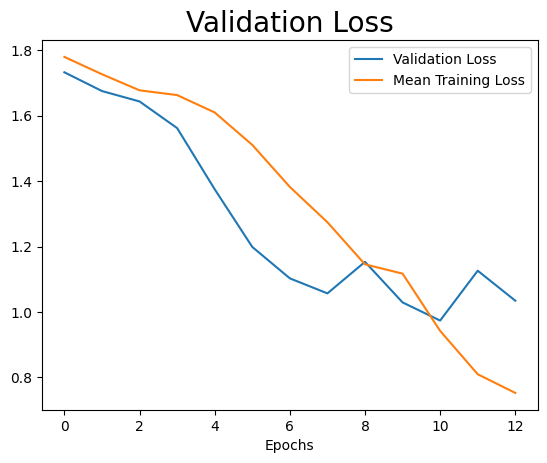

In [27]:
# plt.plot(x_epochs, y_val)

plt.plot(x_epochs, y_val, label="Validation Loss")
plt.plot(x_epochs, y_train, label="Mean Training Loss")
plt.legend()
plt.style.use('fivethirtyeight')
plt.title("Validation Loss")
plt.xlabel("Epochs")


# **Evaluate your model on Test Data**

Now we use our finetuned model to evaluate the test set. We use performance metrics from `sklearn.metrics` to test the effectiveness of our model on unseen test data.

In order to do that, run the finetuned model you have just saved on your test data and report the following performance metrics:



*   Accuracy
*   F1 Score

## Load Best Model

In [28]:
# Modify the location per model
model_location = "/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Text Classification Models/Twitter_Saved_Models/Twitter best_model.pt"
checkpoint = torch.load(model_location)

# Recreate the model architecture
model = AutoModelForSequenceClassification.from_pretrained(
    "Twitter/twhin-bert-base",
    num_labels=6
)

# Load the saved weights
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Twitter/twhin-bert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
              (distance_embedding): Embedding(1023, 64)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=

In [29]:
eval_dataloader = DataLoader(tokenized_validation, batch_size=len(tokenized_validation))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.eval()
test_batch_logits = []
y_true = []
for batch_i, batch in enumerate(eval_dataloader):
    with torch.no_grad():
        # copy input to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].cpu().detach().numpy()

        # output = model(**batch)
        output = model(input_ids, attention_mask=attention_mask)
        test_batch_logits.append(output.logits)
        y_true.extend(labels)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [30]:
print(len(test_batch_logits),len(eval_dataloader))
test_logits = torch.cat(test_batch_logits, dim=0)

#sanity check -> dimension 0 of your logits tensor should be same as the size of the test dataset
print(test_logits.shape,len(tokenized_validation),len(y_true))

1 1
torch.Size([78, 6]) 78 78


In [31]:
#Convert the logits to predicted labels
y_pred = torch.argmax(test_logits, dim = 1).cpu().numpy()
print(y_true[:10])
print(y_pred[:10])

#sanity check: should have as many predictions as labels
assert len(y_pred)==len(y_true)

[np.int64(0), np.int64(1), np.int64(1), np.int64(4), np.int64(2), np.int64(1), np.int64(1), np.int64(1), np.int64(5), np.int64(3)]
[3 1 1 4 4 1 1 1 4 3]


## F1 & Accuracy Scores

In [32]:
print('F1 Score (macro):', f1_score(y_true, y_pred, average='macro'))
print('F1 Score (weighted):', f1_score(y_true, y_pred, average='weighted'))
print('F1 Score (micro):', f1_score(y_true, y_pred, average='micro'))
print('Accuracy Score:', accuracy_score(y_true, y_pred))

F1 Score (macro): 0.6214727600441886
F1 Score (weighted): 0.6346345270521094
F1 Score (micro): 0.6666666666666666
Accuracy Score: 0.6666666666666666


In [49]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=['Failed Compensation/Land Conflict (0)',
                                                          'Environmental Impact',
                                                          'Administrative (2)',
                                                          'Deforestation (3)',
                                                          'Labour Rights (4)',
                                                          'Illegal or Contaminated FFB (5)']))

                                     precision    recall  f1-score   support

Failed Compensation/Land Rights (0)       0.55      0.80      0.65        20
               Environmental Impact       0.95      0.90      0.92        20
                 Administrative (2)       0.43      0.17      0.24        18
                  Deforestation (3)       0.50      0.62      0.56         8
                  Labour Rights (4)       0.75      1.00      0.86         9
    Illegal or Contaminated FFB (5)       1.00      0.33      0.50         3

                           accuracy                           0.67        78
                          macro avg       0.70      0.64      0.62        78
                       weighted avg       0.66      0.67      0.63        78



# Predicting

In [41]:
model_name= "Twitter"

In [48]:
# Load new data for classification
new_data_path = '/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Data/NEW_grievances_formatted.csv'
new_df = pd.read_csv(new_data_path)

print(f"Loaded {len(new_df)} entries for classification")
print("Columns in new data:", new_df.columns.tolist())

# Prepare the text data (assuming 'summary' column contains the text to classify)
# If your text column has a different name, change 'summary' below
text_column = 'Text'

# Convert to Dataset format
new_dataset = Dataset.from_pandas(new_df[[text_column]])

# Tokenize the new data
tokenized_new_data = new_dataset.map(
    lambda example: tokenizer(str(example[text_column]),  # Convert to string to handle NaN
                             padding="max_length",
                             truncation=True,
                             max_length=tokenizer_length)
)

# Set format to torch tensors
tokenized_new_data.set_format("torch")

# Create DataLoader for inference
inference_dataloader = DataLoader(tokenized_new_data, batch_size=batch_size)

# Run inference
model.eval()   # LOAD BEST MSODEL
all_predictions = []

with torch.no_grad():
    for batch in tqdm(inference_dataloader, desc="Classifying"):
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        # Get model predictions
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Convert logits to predicted labels
        predictions = torch.argmax(logits, dim=1).cpu().numpy()
        all_predictions.extend(predictions)

# Read Classification CSV
results_df = pd.read_csv('/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Text Classification Models/classified_grievances.csv')
results_df[f'{model_name}_label'] = all_predictions

print(f"\nClassification complete!")
print(f"Label distribution:")
# Add Label
print(results_df[f'{model_name}_label'].value_counts().sort_index())

output_path = '/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Text Classification Models/classified_grievances.csv'
results_df.to_csv(output_path, index=False)

print("\nFirst 10 classified entries:")
print(results_df[['summary', f'{model_name}_label']].head(10))

Loaded 170 entries for classification
Columns in new data: ['pk', 'Text']


Map:   0%|          | 0/170 [00:00<?, ? examples/s]


Classifying:   0%|          | 0/170 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)

Classifying: 100%|██████████| 170/170 [00:02<00:00, 67.35it/s]


Classification complete!
Label distribution:
Twitter_label
0    67
1     8
2    60
3    23
4    12
Name: count, dtype: int64

First 10 classified entries:


KeyError: "['summary'] not in index"

In [46]:
label_map = {
    0: 'Failed Compensation/Land Rights',
    1: 'Environmental Impact',
    2: 'Administrative',
    3: 'Deforestation',
    4: 'Labour Rights',
    5: 'Illegal or Contaminated FFB'
}

# Merge classified_df with results_df to get the 'manual_label' column
classified_df = classified_df.merge(results_df[['pk', 'manual_label']], on='pk', how='left')

classified_df[f'{model_name}_topic'] = classified_df[f'{model_name}_label'].map(label_map)
display(classified_df[['Text', f'{model_name}_label', 'manual_label', f'{model_name}_topic']].head())

KeyError: "['manual_label'] not in index"

In [ ]:
import matplotlib.pyplot as plt

topic_counts = results_df[f'{model_name}_topic'].value_counts()
print(topic_counts)

plt.figure(figsize=(10, 6))
topic_counts.plot(kind='bar', edgecolor='black')
plt.title('Number of Grievances per Topic')
plt.xlabel('Topic')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
results_df[results_df[f'{model_name}_label'] == 5]

## Accuracy and F1 for Testing Data

In [ ]:
# --- Evaluation ---
true_labels = results_df['manual_label'].astype(int).values
pred_labels = np.array(all_predictions)
print("Evaluation on New Data:")
print("F1 Score (macro):", f1_score(true_labels, pred_labels, average='macro'))
print("F1 Score (weighted):", f1_score(true_labels, pred_labels, average='weighted'))
print("F1 Score (micro):", f1_score(true_labels, pred_labels, average='micro'))
print("Accuracy:", accuracy_score(true_labels, pred_labels))
# Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=[
    'Failed Compensation/Land Rights',
    'Environmental Impact',
    'Administrative',
    'Deforestation',
    'Labour Rights',
    'Illegal or Contaminated FFB'
]))

# Visualization

In [ ]:
# Get counts
manual_counts = results_df['manual_label'].value_counts()
distilbert_counts = results_df['DistilBERT_label'].value_counts()
electra_counts = results_df['Electra_label'].value_counts()
twitter_counts = results_df['Twitter_label'].value_counts()
spanbert_counts = results_df['SpanBERT_label'].value_counts()\

combined_counts = pd.DataFrame({
    'Manual': manual_counts,
    'DistilBERT': distilbert_counts,
    'Electra' : electra_counts,
    'Twitter' : twitter_counts,
    'SpanBERT' : spanbert_counts
}).fillna(0)
combined_counts = combined_counts.sort_index()

# Plot
combined_counts.plot(kind='bar', figsize=(12, 6), edgecolor='black')
plt.title('Number of Grievances per Topic: Manual vs Models')
plt.xlabel('Topic')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Label Source')
plt.tight_layout()
plt.show()
